# 测试狄利克雷

   ## 例子

In [12]:
def dirichlet_split_noniid(train_labels, alpha, n_clients):
    '''
    按照参数为alpha的Dirichlet分布将样本索引集合划分为n_clients个子集
    '''
    n_classes = train_labels.max()+1
    # (K, N) 类别标签分布矩阵X，记录每个类别划分到每个client去的比例
    label_distribution = np.random.dirichlet([alpha]*n_clients, n_classes)
    # (K, ...) 记录K个类别对应的样本索引集合
    class_idcs = [np.argwhere(train_labels == y).flatten()
                  for y in range(n_classes)]

    # 记录N个client分别对应的样本索引集合
    client_idcs = [[] for _ in range(n_clients)]
    for k_idcs, fracs in zip(class_idcs, label_distribution):
        # np.split按照比例fracs将类别为k的样本索引k_idcs划分为了N个子集
        # i表示第i个client，idcs表示其对应的样本索引集合idcs
        for i, idcs in enumerate(np.split(k_idcs,
                                          (np.cumsum(fracs)[:-1]*len(k_idcs)).
                                          astype(int))):
            client_idcs[i] += [idcs]

    client_idcs = [np.concatenate(idcs) for idcs in client_idcs]

    return client_idcs

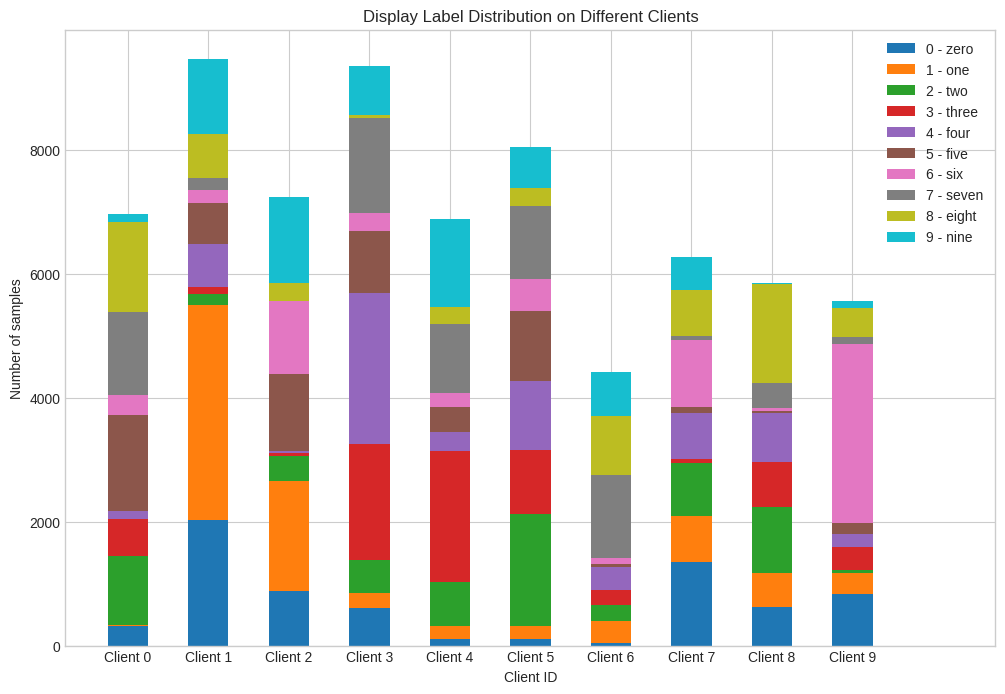

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import ConcatDataset


n_clients = 10
dirichlet_alpha = 1.0
seed = 42


np.random.seed(seed)
train_data = datasets.MNIST(
    root="~/data", download=True, train=True)
test_data = datasets.MNIST(
    root="~/data", download=True, train=False)

classes = train_data.classes
n_classes = len(classes)

labels = np.concatenate(
    [np.array(train_data.targets), np.array(test_data.targets)], axis=0)
dataset = ConcatDataset([train_data, test_data])

# 我们让每个client不同label的样本数量不同，以此做到Non-IID划分
client_idcs = dirichlet_split_noniid(
    labels, alpha=dirichlet_alpha, n_clients=n_clients)

# 展示不同client上的label分布
plt.figure(figsize=(12, 8))
label_distribution = [[] for _ in range(n_classes)]
for c_id, idc in enumerate(client_idcs):
    for idx in idc:
        label_distribution[labels[idx]].append(c_id)

plt.hist(label_distribution, stacked=True,
            bins=np.arange(-0.5, n_clients + 1.5, 1),
            label=classes, rwidth=0.5)
plt.xticks(np.arange(n_clients), ["Client %d" %
                                    c_id for c_id in range(n_clients)])
plt.xlabel("Client ID")
plt.ylabel("Number of samples")
plt.legend()
plt.title("Display Label Distribution on Different Clients")
plt.show()

## 分析

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import ConcatDataset

# 加载您的CSV数据集（请将“your_dataset.csv”替换为实际的文件路径）
df = pd.read_csv("/home/raoxy/data/Car_Hacking_5.csv").sample(frac=1).reset_index(drop=True)
# 获取特征列和类别列
features = df.iloc[:, :-1]
train_labels = df.iloc[:, -1]
n_clients=15

In [15]:
# dataset = ConcatDataset([train_data, test_data])
alpha=1
n_classes = len(train_labels.value_counts())+1 # 获得分类数目
label_distribution = np.random.dirichlet([alpha]*n_clients, n_classes) 
label_distribution # (K, N) 类别标签分布矩阵X，记录每个类别划分到每个client去的比例 n_classes*n_clients

array([[6.81334016e-02, 6.52195751e-02, 5.06264247e-03, 8.58919005e-03,
        8.92390034e-02, 1.14182368e-01, 5.57003886e-02, 1.01686533e-02,
        1.90715621e-01, 1.99358652e-02, 3.54862764e-02, 5.90549680e-03,
        5.34795320e-03, 3.24525659e-01, 1.78790635e-03],
       [8.51951324e-03, 1.26515341e-03, 1.98910007e-02, 1.95284524e-01,
        1.09877368e-02, 9.67283057e-02, 4.38870714e-02, 2.13520463e-02,
        1.47817920e-01, 1.93812591e-01, 6.37196505e-02, 5.63705893e-02,
        2.72932445e-02, 1.01539583e-01, 1.15310701e-02],
       [2.85750311e-02, 2.05695730e-01, 4.62410330e-02, 9.95988453e-02,
        2.98109897e-02, 1.67872824e-02, 2.69962764e-02, 2.09312281e-02,
        2.71299657e-02, 1.81097946e-01, 1.63139914e-02, 5.49048117e-02,
        9.25853240e-02, 1.19521095e-01, 3.38104496e-02],
       [1.04685077e-02, 1.34338432e-03, 1.80051321e-02, 5.11400196e-02,
        1.09183969e-01, 6.79448187e-02, 4.42315411e-02, 1.75937833e-01,
        2.14145588e-02, 3.63456149e-0

In [16]:
rdf = df[df["Label"]=="R"].reset_index(drop=True)
num_rows = len(rdf)

In [17]:
ratios = label_distribution[0]
# 计算每个分割的行数
split_sizes = (num_rows * ratios).astype(int)
split_sizes

array([ 47818,  45773,   3553,   6028,  62630,  80136,  39092,   7136,
       133850,  13991,  24905,   4144,   3753, 227762,   1254])

In [18]:
if split_sizes.sum() != num_rows:
    split_sizes[-1] += num_rows - split_sizes.sum()

In [19]:
splits = []
start_idx = 0
for size in split_sizes:
    end_idx = start_idx + size
    splits.append(df.iloc[start_idx:end_idx])
    start_idx = end_idx

# 验证每个分割的长度
for i, split in enumerate(splits):
    print(f"分割 {i} 的长度: {len(split)}")

分割 0 的长度: 47818
分割 1 的长度: 45773
分割 2 的长度: 3553
分割 3 的长度: 6028
分割 4 的长度: 62630
分割 5 的长度: 80136
分割 6 的长度: 39092
分割 7 的长度: 7136
分割 8 的长度: 133850
分割 9 的长度: 13991
分割 10 的长度: 24905
分割 11 的长度: 4144
分割 12 的长度: 3753
分割 13 的长度: 227762
分割 14 的长度: 1261


In [ ]:
client[0]["R"].splits[0]

## 我的函数

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets
from torch.utils.data import ConcatDataset
import pandas as pd

# 加载您的CSV数据集（请将“your_dataset.csv”替换为实际的文件路径）
df = pd.read_csv("/home/raoxy/data/Car_Hacking_5.csv").sample(frac=1).reset_index(drop=True)

In [22]:
df.Label.value_counts()

R        701832
RPM       32539
gear      29944
DoS       29501
Fuzzy     24624
Name: Label, dtype: int64

In [23]:
n_clients=15 # 创建客户端
client=[ pd.DataFrame(columns=[str(i) for i in df.columns]) for i in range(n_clients) ]
client[0]

,CAN ID,DATA[0],DATA[1],DATA[2],DATA[3],DATA[4],DATA[5],DATA[6],DATA[7],Label


In [24]:
alpha=1
n_classes = len(df.Label.value_counts()) # 获得分类数目
label_distribution = np.random.dirichlet([alpha]*n_clients, n_classes) 

def dirichlet_non_iid(df,client):
    num_rows = len(df)
    for ld in label_distribution: # 一共循环5次，5个类别
        np.random.shuffle(ld)
        split_sizes = (num_rows * ld).astype(int) # 计算每个客户端的分割行数
        if split_sizes.sum() != num_rows: # 调整最后一行的数量
            split_sizes[-1] += num_rows - split_sizes.sum()
        splits = []
        start_idx = 0
        for size in split_sizes:
            end_idx = start_idx + size
            splits.append(df.iloc[start_idx:end_idx])
            start_idx = end_idx
            
        # 验证每个分割的长度
        for i, split in enumerate(splits):
            client[i]=pd.concat([client[i],split])
        return client

In [25]:
client = dirichlet_non_iid(df[df["Label"]=="R"].reset_index(drop=True),client)
client = dirichlet_non_iid(df[df["Label"]=="RPM"].reset_index(drop=True),client)
client = dirichlet_non_iid(df[df["Label"]=="gear"].reset_index(drop=True),client)
client = dirichlet_non_iid(df[df["Label"]=="DoS"].reset_index(drop=True),client)
client = dirichlet_non_iid(df[df["Label"]=="Fuzzy"].reset_index(drop=True),client)
client[0].Label.value_counts()

R        51695
RPM       1553
DoS       1504
gear       287
Fuzzy       37
Name: Label, dtype: int64

In [26]:
R=[]
Rpm=[]
gear=[]
dos=[]
Fuzzy=[]
for i in range(len(client)):
    R.append(client[i].Label.value_counts()[0])
    Rpm.append(client[i].Label.value_counts()[1])
    gear.append(client[i].Label.value_counts()[2])
    dos.append(client[i].Label.value_counts()[3])
    Fuzzy.append(client[i].Label.value_counts()[4])

In [27]:
ldf= pd.DataFrame({
    "R":R,
    "gear":gear,
    "DoS":dos,
    "RPM":Rpm,
    "Fuzzy":Fuzzy
}).T
ldf.columns=["RSU "+str(i) for i in range(1,16)]
ldf=ldf.T

In [28]:
df_normalized = ldf.div(ldf.max(axis=0), axis=1)
df_normalized

,R,gear,DoS,RPM,Fuzzy
RSU 1,0.325539,0.332082,0.119783,0.210948,0.017771
RSU 2,0.042664,0.543829,0.692404,0.465499,0.518732
RSU 3,0.330363,0.523515,0.896912,0.566151,0.861671
RSU 4,0.369066,0.272246,0.507095,0.756724,0.504323
RSU 5,0.225337,0.309340,0.487896,0.343928,0.149856
RSU 6,0.373789,0.406271,0.644825,0.299511,0.676273
RSU 7,0.063256,0.551998,1.000000,0.557729,0.381364
RSU 8,1.000000,0.277103,0.194073,0.194105,0.202690
RSU 9,0.042463,0.453963,0.636895,0.338902,0.024015
RSU 10,0.209965,1.000000,0.756678,0.906547,0.682997


In [29]:
# import matplotlib.pyplot as plt     
# print(plt.style.available)

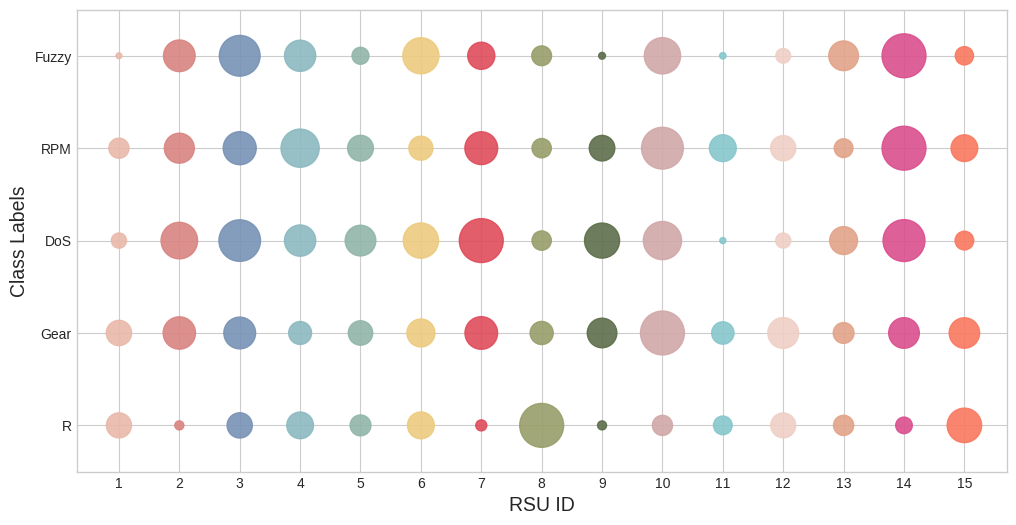

In [30]:
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
# 布置画布
fig = plt.figure(figsize=(12, 6))
colors=['#E9B9AA','#D98481','#7892B5','#8CB9C0','#91B5A9','#EDCA7F',
       '#DF4C5B','#989E6A','#5D6E4A','#D1A8A8','#86c7cc','#efcfc5',
       '#e2a388','#da4f8e','#f9785f']
Y=[int(i) for i in range(1,6)]
for j in range(15): # RSU
    plt.scatter(x=np.full(5, j+1),y=Y,s=[ i*1000 for i in df_normalized.iloc[j] ],color=colors[j],alpha=0.9) # RSU 1
#     plt.scatter(x=np.full(5, j+1),y=Y,s=[ i/ldf.iloc[j].sum()*500 for i in ldf.iloc[j] ]) # RSU 1
    
# plt.grid()
# 自定义y轴刻度标签
# 假设我们想要设置特定的y值及其对应的标签
yticks_positions = [1, 2,3,4,5]  # y轴刻度的位置
yticks_labels = ['R','Gear','DoS','RPM','Fuzzy']  # 对应的y轴刻度标签
# 使用plt.yticks()设置自定义的y轴刻度标签
plt.yticks(yticks_positions, yticks_labels)
plt.ylim(0.5,5.5)
xticks_positions = [i for i in range(1,16)]  # y轴刻度的位置
plt.xticks(xticks_positions, xticks_positions)

# 添加坐标轴标签
plt.xlabel('RSU ID',fontsize=14)
plt.ylabel('Class Labels',fontsize=14)
plt.show()

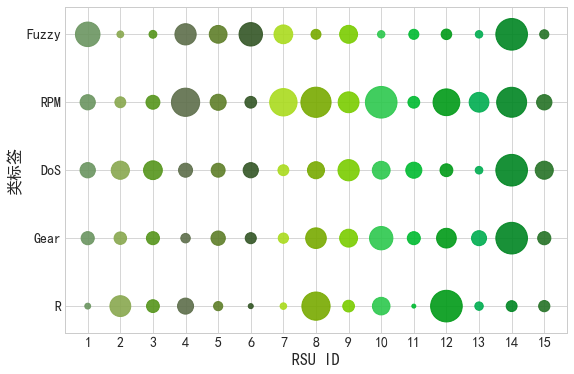

In [3]:
import numpy as np
# from torchvision import datasets
# from torch.utils.data import ConcatDataset
import pandas as pd

# 设置全局字体大小为12

# 设置全局字体加粗
# plt.rcParams['font.weight'] = 'bold'
# 设置全局字体为SimSun和Times New Roman
# plt.rcParams['font.family'] = ['SimSun','Times New Roman']
# plt.rcParams['font.weight'] = 'bold'
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
plt.rcParams['font.sans-serif'] = ['SimHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号'-'显示为方块的问题


# plt.rcParams['font.family']=['Times New Roman ,SimSun ']# 设置字体族，中文为SimSun，英文为Times New Roman
# plt.rcParams['mathtext.fontset'] = 'stix' # 设置数学公式字体为stix
plt.rcParams['font.size'] = 16

df = pd.read_csv("dirichlet_0.5.csv")
df_normalized=df[['R','gear','DoS','RPM','Fuzzy']]
# 布置画布
fig = plt.figure(figsize=(9, 6))
colors = ['#6b9560','#89a84f',  '#55951b', '#5D6E4A', '#5e7e29', '#335525',
          '#aadb1e', '#78aa00','#7acc00','#2cc84d', '#00bb31', '#009a17',
          '#00ad50', '#008522','#257226']
Y=[int(i) for i in range(1,6)]
for j in range(15): # RSU
    plt.scatter(x=np.full(5, j+1),y=Y,s=[ i*1000 for i in df_normalized.iloc[j] ],color=colors[j],alpha=0.9) # RSU 1
#     plt.scatter(x=np.full(5, j+1),y=Y,s=[ i/ldf.iloc[j].sum()*500 for i in ldf.iloc[j] ]) # RSU 1

# plt.grid()
# 自定义y轴刻度标签
# 假设我们想要设置特定的y值及其对应的标签
yticks_positions = [1, 2,3,4,5]  # y轴刻度的位置
yticks_labels = ['R','Gear','DoS','RPM','Fuzzy']  # 对应的y轴刻度标签
# 使用plt.yticks()设置自定义的y轴刻度标签
plt.yticks(yticks_positions, yticks_labels,fontsize=14)
plt.ylim(0.6,5.4)
xticks_positions = [i for i in range(1,16)]  # y轴刻度的位置
plt.xticks(xticks_positions, xticks_positions ,fontsize=14)
# plt.grid()
# 添加坐标轴标签
plt.xlabel('RSU ID',fontsize=16)
plt.ylabel('类标签',fontsize=16)
plt.show()